Bigru. Need to run it in colab because GPU required rather than regular CPU

source: https://www.kaggle.com/alber8295/bigru-w-attention-visualized-for-beginners


The notebook is equivalent for both GloVe embeddings tried (standard and Twitter)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
# Basic
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, random, math
from sklearn.model_selection import train_test_split
from sklearn import metrics

# DL
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Model
from keras.layers import Layer, Input, Embedding, Dropout, SpatialDropout1D, GlobalAveragePooling1D, Attention
from keras.layers import GlobalMaxPooling1D, Bidirectional, GRU, CuDNNGRU, Activation, Dense
from keras.layers import Dot, Reshape, TimeDistributed, concatenate, BatchNormalization
from keras import initializers, regularizers, constraints
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


# Visualization
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import seaborn as sns
sns.set()

In [ ]:
#Hyperparameters

EMB_SIZE = 100
MAX_FEATURES = 50000 # how many unique words to use (i.e num rows in embedding vector)
MAX_LEN = 100 # Maximum length for texts
EMBEDDING_FILE = "/content/drive/MyDrive/Thesis/Data/Embedding files/glove.twitter.27B.100d.txt"

In [ ]:
# Util functions
# Custom F1 callback
class F1Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_pred = (y_pred > 0.35).astype(int)
            score = metrics.f1_score(self.y_val, y_pred, average="micro")
            print("\n F1 Score - epoch: %d - score: %.6f \n" % (epoch+1, score))

def make_plot(loss, val_loss, acc, val_acc):
    t = np.arange(1,len(loss)+1,1)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
    plt.subplots_adjust(wspace=0.2)

    ax1.plot(t, loss)
    ax1.plot(t, val_loss)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title('Train vs Val loss')
    ax1.legend(['train','val'], ncol=2, loc='upper right')

    ax2.plot(t, acc)
    ax2.plot(t, val_acc)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('acc')
    ax2.set_title('Train vs Val acc')
    ax2.legend(['train','val'], ncol=2, loc='upper right')

    plt.show();

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)

def visualize_attention():
    # Make new model for output predictions and attentions
    model_att = Model(inputs=model.input, \
                            outputs=[model.output, model.get_layer('attention_vec').output])
    idx = np.random.randint(low = 0, high=X_te.shape[0]) # Get a random test
    tokenized_sample = np.trim_zeros(X_te[idx]) # Get the tokenized text
    label_probs, attentions = model_att.predict(X_te[idx:idx+1]) # Perform the prediction

    # Get decoded text and labels
    id2word = dict(map(reversed, tokenizer.word_index.items()))
    decoded_text = [id2word[word] for word in tokenized_sample] 
    
    # Get classification
    label = np.argmax((label_probs>0.5).astype(int).squeeze()) # Only one
    label2id = ['Sincere', 'Insincere']

    # Get word attentions using attenion vector
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0
    for token, attention_score in zip(decoded_text, attentions[0][-len(tokenized_sample):]):
        token_attention_dic[token] = attention_score
        

    # Build HTML String to viualize attentions
    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    for token, attention in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                            token)
    #html_text += "</p><br>"
    #html_text += "<p style='font-size: large'><b>Classified as:</b> "
    #html_text += label2id[label] 
    #html_text += "</p>"
    
    # Display text enriched with attention scores 
    display(HTML(html_text))
    
    # PLOT EMOTION SCORES
    
    _labels = ['sincere', 'insincere']
    plt.figure(figsize=(5,2))
    plt.bar(np.arange(len(_labels)), label_probs.squeeze(), align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
    plt.xticks(np.arange(len(_labels)), _labels)
    plt.ylabel('Scores')
    plt.show()
    
def under_sample(train_df):
    # UNDER SAMPLE
    insincere = len(train_df[train_df.target == 1])
    insincere_indices = train_df[train_df.target == 1].index

    sincere_indices = train_df[train_df.target == 0].index
    random_indices = np.random.choice(sincere_indices, insincere, replace=False)

    under_sample_indices = np.concatenate([insincere_indices,random_indices])
    under_sample = train_df.loc[under_sample_indices]
    train_df = under_sample.sample(frac=1)
    train_df.info()
    return train_df

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

def get_embeddings_matrix():
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE,encoding="UTF-8"))

    word_index = tokenizer.word_index
    nb_words = min(MAX_FEATURES, len(word_index))
    print('nb_words: %d' % nb_words)
    embedding_matrix = np.zeros((nb_words, EMB_SIZE))
    print('Embedding matrix shape: %d/%d' % (nb_words, EMB_SIZE))
    for word, i in word_index.items():
        if i >= nb_words: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    return embedding_matrix

def visualize_attention():
    # Make new model for output predictions and attentions
    '''
    model.get_layer('attention_vec').output:
    attention_vec (Attention)    [(None, 128), (None, 54)] <- We want (None,54) that is the word att
    '''
    model_att = Model(inputs=model.input, \
                            outputs=[model.output, model.get_layer('attention_vec').output[-1]])
    idx = np.random.randint(low = 0, high=X_te.shape[0]) # Get a random test
    tokenized_sample = np.trim_zeros(X_te[idx]) # Get the tokenized text
    label_probs, attentions = model_att.predict(X_te[idx:idx+1]) # Perform the prediction

    # Get decoded text and labels
    id2word = dict(map(reversed, tokenizer.word_index.items()))
    decoded_text = [id2word[word] for word in tokenized_sample] 
    
    # Get classification
    label = (label_probs>0.5).astype(int).squeeze() # Only one
    label2id = ['Sincere', 'Insincere']

    # Get word attentions using attenion vector
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0
    
    attentions_text = attentions[0,-len(tokenized_sample):]
    #plt.bar(np.arange(0,len(attentions.squeeze())), attentions.squeeze())
    #plt.show();
    #print(attentions_text)
    attentions_text = (attentions_text - np.min(attentions_text)) / (np.max(attentions_text) - np.min(attentions_text))
    for token, attention_score in zip(decoded_text, attentions_text):
        #print(token, attention_score)
        token_attention_dic[token] = attention_score
        

    # Build HTML String to viualize attentions
    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    for token, attention in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                            token)
    #html_text += "</p><br>"
    #html_text += "<p style='font-size: large'><b>Classified as:</b> "
    #html_text += label2id[label] 
    #html_text += "</p>"
    
    # Display text enriched with attention scores 
    display(HTML(html_text))
    
    # PLOT EMOTION SCORES
    _labels = ['sincere', 'insincere']
    probs = np.zeros(2)
    probs[1] = label_probs
    probs[0] = 1- label_probs
    plt.figure(figsize=(5,2))
    plt.bar(np.arange(len(_labels)), probs.squeeze(), align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
    plt.xticks(np.arange(len(_labels)), _labels)
    plt.ylabel('Scores')
    plt.show()

In [ ]:
# Util classes
class Attention(Layer):
      
    def __init__(self,
                W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, return_attention=False,
                 **kwargs):
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = K.squeeze(K.dot(x, K.expand_dims(self.W)), axis=-1)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
# use the first 2 lines of the file to detect separator
#temp_lines = csv_file.readline() + '\n' + csv_file.readline()
#dialect = csv.Sniffer().sniff(temp_lines, delimiters=';,')

# remember to go back to the start of the file for the next time it's read
#csv_file.seek(0) 

#df = pd.read_csv(csv_file, sep=dialect.delimiter)

In [ ]:
# Load data and split train/test
train_df = pd.read_csv("/content/drive/MyDrive/Thesis/Data/Filled Datasets/Second dataset (Kaggle)/Preprocessed/combined_train_val.csv")
test_df = pd.read_excel("/content/drive/MyDrive/Thesis/Data/Filled Datasets/Second dataset (Kaggle)/Preprocessed/Constraint_Test_fullprep_with_labels.xlsx")
#train_df, test_df = train_test_split(data, test_size=0.33,random_state = 2022)
train_df, val_df = train_test_split(train_df, test_size=0.05,random_state = 2022)

In [ ]:
# RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=47)

# fit predictor and target variable
train_df, label_train = ros.fit_resample(train_df,train_df["label"])
val_df, label_val = ros.fit_resample(val_df,val_df["label"])

#text = pd.DataFrame(data_os["text"])
#label_os = pd.DataFrame(label_os)

In [ ]:
train_df = train_df.rename(columns={"tweet": "text"})
test_df = test_df.rename(columns={"tweet": "text"})
val_df = val_df.rename(columns={"tweet": "text"})

In [ ]:
test_df

In [ ]:
## some config values 
embed_size = 100 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 300 # max number of words in a question to use

X_tra = train_df["text"].fillna("_na_").values
X_val = val_df["text"].fillna("_na_").values
X_te = test_df["text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(X_tra))
X_tra = tokenizer.texts_to_sequences(X_tra)
X_val = tokenizer.texts_to_sequences(X_val)
X_te = tokenizer.texts_to_sequences(X_te)

## Pad the sentences 
MAX_LEN = min(MAX_LEN, len(max(X_tra, key=len)))
X_tra = pad_sequences(X_tra, maxlen=MAX_LEN)
X_val = pad_sequences(X_val, maxlen=MAX_LEN)
X_te = pad_sequences(X_te, maxlen=MAX_LEN)

## Get the target values
Y_tra = label_train
Y_val = label_val
Y_te = test_df["label"].fillna("_na_").values

In [ ]:
embedding_matrix = get_embeddings_matrix()

nb_words: 11147
Embedding matrix shape: 11147/100


In [ ]:
X_tra.shape[1]

100

In [ ]:
# Define input tensor
inp = Input(shape=(X_tra.shape[1],), dtype='int32')

# Word embedding layer
embedded_inputs = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                            weights=[embedding_matrix], trainable = False)(inp)

# Apply dropout to prevent overfitting
embedded_inputs = SpatialDropout1D(0.2)(embedded_inputs)

# Apply Bidirectional GRU over embedded inputs
rnn_outs = Bidirectional(\
                CuDNNGRU(64, return_sequences=True))(embedded_inputs)
rnn_outs = Dropout(0.2)(rnn_outs) # Apply dropout to GRU outputs to prevent overfitting

# Attention Mechanism - Generate attention vectors
sentence, word_scores = Attention(return_attention=True, name = "attention_vec")(rnn_outs)

# Dense layers
fc = Dense(64, activation='relu')(sentence)
fc = Dropout(0.5)(fc)
output = Dense(1, activation='sigmoid')(fc)

# Finally building model
model = Model(inputs=inp, outputs=output)
model.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer='adam')

# Print model summary
model.summary()

In [ ]:
# Train model
F1_Score = F1Evaluation(validation_data=(X_val, Y_val), interval=1)
hist = model.fit(X_tra, Y_tra, validation_data=(X_val, Y_val), 
                 epochs=15, batch_size=512, callbacks=[F1_Score])
val_loss = hist.history['val_loss']; val_acc = hist.history['val_accuracy']
loss = hist.history['loss'];acc = hist.history['accuracy']
#solution to error: conclusion from online research seems to be that i have to switch to GPU in colab.
#problem: we don't have a gpu --> solved, we do. Go to 'resources bekijken' --> 'runtimetype wijzigen' --> GPU

#have a look at bazel(isk): https://github.com/bazelbuild/bazelisk
#and the compatibilities: https://www.tensorflow.org/install/source_windows

Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9666
 F1 Score - epoch: 1 - score: 0.905830 

17/17 [==============================] - 2s 103ms/step - loss: 0.0922 - accuracy: 0.9666 - val_loss: 0.2669 - val_accuracy: 0.9103
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9689
 F1 Score - epoch: 2 - score: 0.908072 

17/17 [==============================] - 1s 85ms/step - loss: 0.0885 - accuracy: 0.9689 - val_loss: 0.2736 - val_accuracy: 0.9103
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9668
 F1 Score - epoch: 3 - score: 0.908072 

17/17 [==============================] - 1s 84ms/step - loss: 0.0900 - accuracy: 0.9668 - val_loss: 0.2568 - val_accuracy: 0.9103
Epoch 4/15
16/17 [===========================>..] - ETA: 0s - loss: 0.0859 - accuracy: 0.9691
 F1 Score - epoch: 4 - score: 0.912556 

17/17 [==============================] - 1s 76ms/step - loss: 0.0861 

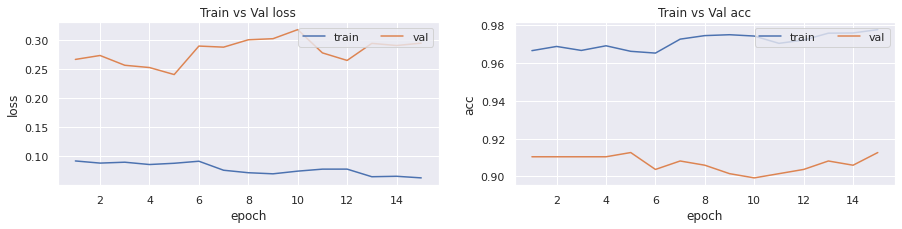

In [ ]:
make_plot(loss, val_loss, acc, val_acc)


In [ ]:
val_pred = model.predict([X_val], batch_size=1024, verbose=1)
f1s = []
max_thresh, max_f1 = 0, 0
for thresh in np.arange(0.1, 0.9, 0.01):
    f1s.append(metrics.f1_score(Y_val, (val_pred>thresh)))
max_f1 = np.max(f1s)
max_thresh = np.arange(0.1, 0.9, 0.01)[np.argmax(f1s)]
print('Validation set: Max F1-Score: %.2f - reached with threshold: %.2f' % (max_f1, max_thresh))

1/1 [==============================] - 1s 856ms/step
Validation set: Max F1-Score: 0.92 - reached with threshold: 0.10


In [ ]:
np.unique(val_pred)

In [ ]:
for _ in range(25):
    visualize_attention()

In [ ]:
test_pred = model.predict([X_te], batch_size=1024, verbose=1)
test_pred_thresh = (test_pred>max_thresh).astype(int)

3/3 [==============================] - 0s 49ms/step



1.   no oversampling: always predicts 0 (real)


1.   if oversampling and 3 epochs (same for 15 epochs): always predicts 1 (fake)




In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
test_pred = test_pred.round()

print(metrics.classification_report(Y_te, test_pred,  digits=5))
print(confusion_matrix(Y_te, test_pred))


              precision    recall  f1-score   support

           0    0.92431   0.92761   0.92596      1119
           1    0.92028   0.91667   0.91847      1020

    accuracy                        0.92239      2139
   macro avg    0.92229   0.92214   0.92221      2139
weighted avg    0.92239   0.92239   0.92239      2139

[[1038   81]
 [  85  935]]
